In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])

In [3]:

# CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

# Data

## CIFAR-10

CIFAR-10 is a popular dataset used for training computers to recognise images. Here’s what makes it special:

### Overview

- Contains 60,000 small colour images.
- Each image has a resolution of 32x32 pixels.
- Images are divided into 10 distinct categories.

### Categories

- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

### Dataset Split

- **Training set:** 50,000 images (5,000 per category)
- **Test set:** 10,000 images (1,000 per category)

Each category has an equal number of images, ensuring balanced classes.





In [4]:
# Model
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Sequential(
            nn.Linear(4*4*128, 512), nn.ReLU(), nn.Dropout(0.3)
        )
        # Classifier
        self.classifier = nn.Linear(512, 10)
        # Decoder
        self.fc_dec = nn.Sequential(
            nn.Linear(512, 4*4*128), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), nn.Tanh()
        )

    def forward(self, x):
        x_enc = self.enc(x)
        x_flat = self.flatten(x_enc)
        z = self.fc_enc(x_flat)
        class_out = self.classifier(z)
        x_dec = self.fc_dec(z).view(-1, 128, 4, 4)
        recon = self.dec(x_dec)
        return recon, class_out, z

model = Autoencoder().to(device)


## Model: Autoencoder with Classifier

I created a simple convolutional autoencoder model that does two things:

- **Reconstruct Images:** Compresses images into smaller features and rebuilds them.
- **Classify Images:** Predicts which class each image belongs to from these features.

### How it works:

- **Encoder:** Uses convolutional layers to shrink images into smaller representations.
- **Classifier:** Predicts image labels from these small representations.
- **Decoder:** Expands representations back into images.

### Output:

The model outputs:

- A reconstructed image.
- Predicted class labels.
- A compressed feature representation.

https://www.analyticsvidhya.com/blog/2021/06/complete-guide-on-how-to-use-autoencoders-in-python/

In [5]:
# Losses
cross_entropy = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()

def ssim_loss(x, y):
    from pytorch_msssim import ssim
    return 1 - ssim(x, y, data_range=2.0, size_average=True)

# Optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        recon, preds, _ = model(imgs)

        loss_recon = ssim_loss(recon, imgs)
        loss_cls = cross_entropy(preds, labels)
        loss = 0.4 * loss_recon + 0.6 * loss_cls

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(trainloader):.4f}")

Epoch 1, Loss: 1.1485
Epoch 2, Loss: 0.8691
Epoch 3, Loss: 0.7760
Epoch 4, Loss: 0.6998
Epoch 5, Loss: 0.6391
Epoch 6, Loss: 0.5880
Epoch 7, Loss: 0.5472
Epoch 8, Loss: 0.5061
Epoch 9, Loss: 0.4711
Epoch 10, Loss: 0.4449
Epoch 11, Loss: 0.4209
Epoch 12, Loss: 0.4034
Epoch 13, Loss: 0.3910
Epoch 14, Loss: 0.3725
Epoch 15, Loss: 0.3653
Epoch 16, Loss: 0.3604
Epoch 17, Loss: 0.3541
Epoch 18, Loss: 0.3512
Epoch 19, Loss: 0.3483
Epoch 20, Loss: 0.3476
Epoch 21, Loss: 0.3395
Epoch 22, Loss: 0.3364
Epoch 23, Loss: 0.3357
Epoch 24, Loss: 0.3368
Epoch 25, Loss: 0.3401
Epoch 26, Loss: 0.3283
Epoch 27, Loss: 0.3328
Epoch 28, Loss: 0.3308
Epoch 29, Loss: 0.3268
Epoch 30, Loss: 0.3243


In [7]:
# Feature extraction
model.eval()
features = []
true_labels = []
with torch.no_grad():
    for imgs, labels in trainloader:
        imgs = imgs.to(device)
        _, _, z = model(imgs)
        features.append(z.cpu().numpy())
        true_labels.append(labels.numpy())
features = np.concatenate(features)
true_labels = np.concatenate(true_labels)

In [8]:
# Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(features)
sil_score = silhouette_score(features, clusters)
print(f"Silhouette Score: {sil_score:.4f}")


Silhouette Score: 0.0401


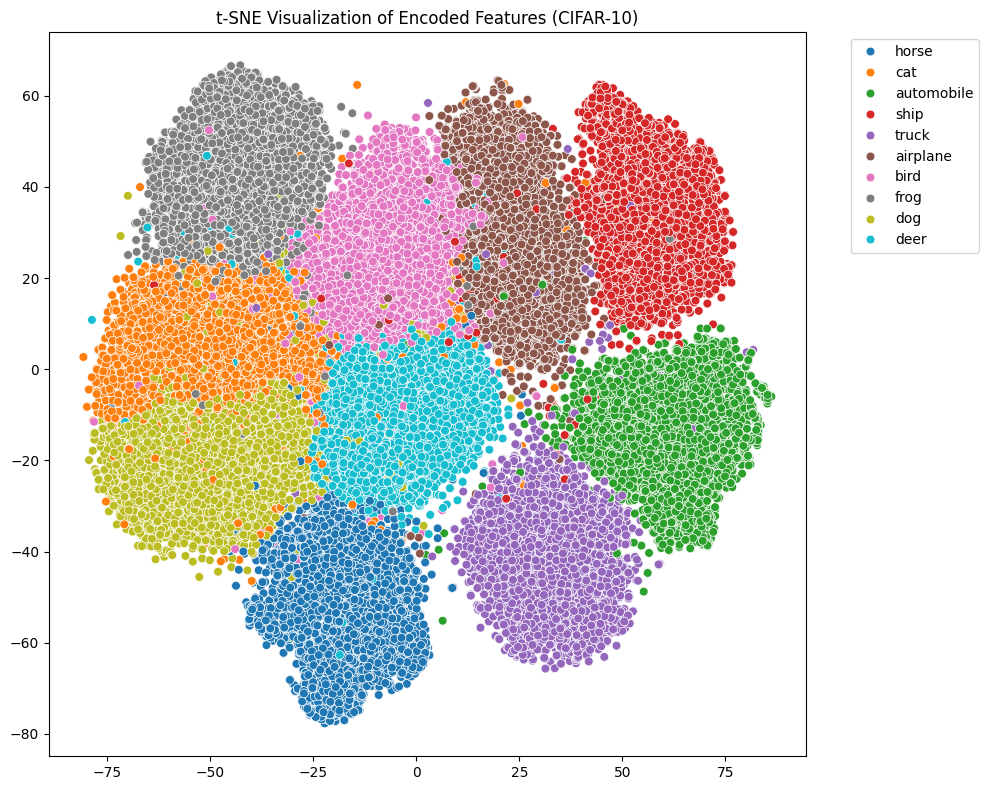

In [9]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
named_labels = [trainset.classes[i] for i in true_labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=named_labels, palette="tab10", s=40)
plt.title("t-SNE Visualization of Encoded Features (CIFAR-10)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# Reconstruction
model.eval()
x_test_samples = next(iter(testloader))[0][:10].to(device)
with torch.no_grad():
    recons, _, _ = model(x_test_samples)

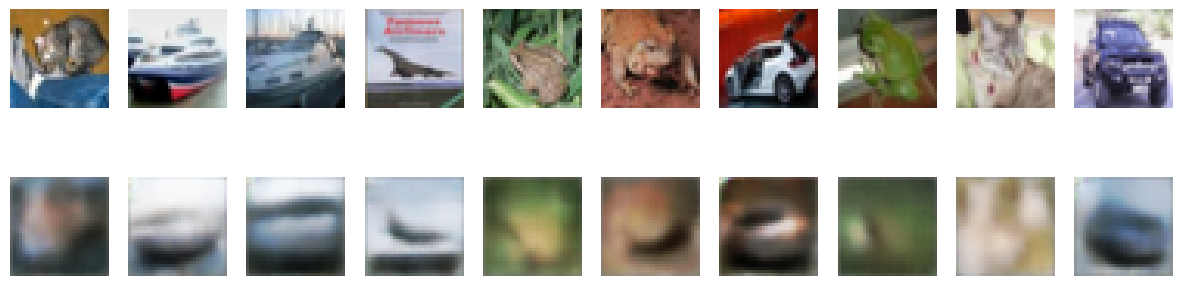

In [11]:
# Plot
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow((x_test_samples[i].cpu().permute(1, 2, 0) + 1) / 2)
    axes[1, i].imshow((recons[i].cpu().permute(1, 2, 0) + 1) / 2)
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.show()


In [12]:
# MSE Evaluation
test_imgs = torch.cat([imgs for imgs, _ in testloader], dim=0).to(device)
with torch.no_grad():
    recons, _, _ = model(test_imgs)
    mse = mse_loss(recons, test_imgs).item()
print(f"Average MSE on test set: {mse:.4f}")

Average MSE on test set: 0.1036
